In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn
from sklearn.model_selection import train_test_split
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

C:\Users\Public\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Load data from CSV file and perform data preprocessing
df = pd.read_csv('df_mostfre_diabetes.csv')

In [4]:
X = df.loc[:, df.columns != 'DIQ010']
y = df.DIQ010

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [5]:
# Address class imbalance by oversampling training data using SMOTE
smote = SMOTE(random_state=0)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = smote.fit_resample(X_test, y_test)
X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
X_test_sm = pd.DataFrame(X_test_sm, columns=X.columns)

In [6]:
# Train XGBoost model using oversampled training data
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train_sm, y_train_sm)
y_pred_sm = model.predict(X_test_sm)

C:\Users\Public\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[05:33:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot: >

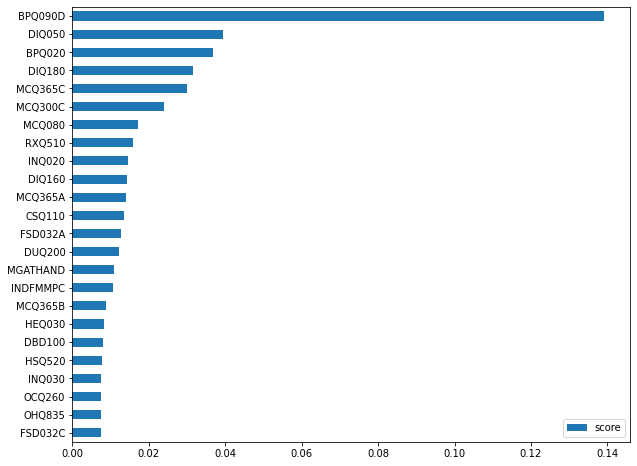

In [7]:
# Features selected by XGBoost
keys = list(model.get_booster().feature_names)
values = list(model.feature_importances_)
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 24 features
xgbfs_ = data[:24]

# Plot feature score
xgbfs_.sort_values(by='score').plot(kind='barh', figsize=(10, 8))


In [8]:
# final variables
var_list = [ 'BPQ020', 'DIQ180', 'MCQ365C', 'MCQ300C', 'MCQ080', 'INQ020', 'CSQ110', 'FSD032A', 'DUQ200', 'MGATHAND', 'MCQ365B', 'HEQ030', 'DBD100', 'HSQ520', 'INQ030', 'OCQ260', 'OHQ835', 'FSD032C', 'DIQ010']
df_final = df.filter(var_list)

In [9]:
X_ = df_final.loc[:, df_final.columns != 'DIQ010']
y = df_final.DIQ010

# Data transformation by MinMax Scaler
minmax=MinMaxScaler()
X = pd.DataFrame(minmax.fit_transform(X_), columns=X_.columns)

In [10]:
# Split final data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [11]:
#Should not resample test set and val set
smote = SMOTE(random_state=0)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)

In [13]:
# Define function to print confusion matrix
def confusion(y_test, y_pred):
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
    print('Confusion Matrix:')
    print(conf)
    return conf

In [13]:
# Train Logistic regression model with default parameters and print evaluation metrics
lr_clf = LogisticRegression(random_state=11).fit(X_train_sm, y_train_sm)
y_pred_lr1 = lr_clf.predict(X_test)
accuracy = lr_clf.score(X_test, y_test)

print('Accuracy Score:', accuracy)
print('Prediction:', y_pred_lr1)

print(classification_report(y_test, y_pred_lr1))
confusion(y_test, y_pred_lr1)

Accuracy Score: 0.7670863309352518
Prediction: [0 0 1 ... 1 0 0]
              precision    recall  f1-score   support

           0       0.96      0.75      0.85       939
           1       0.39      0.84      0.53       173

    accuracy                           0.77      1112
   macro avg       0.67      0.80      0.69      1112
weighted avg       0.87      0.77      0.80      1112

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         708         231
True[1]          28         145


,Predict[0],Predict[1]
True[0],708,231
True[1],28,145


roc_auc_score for Logistic Regression:  0.8628721983169896


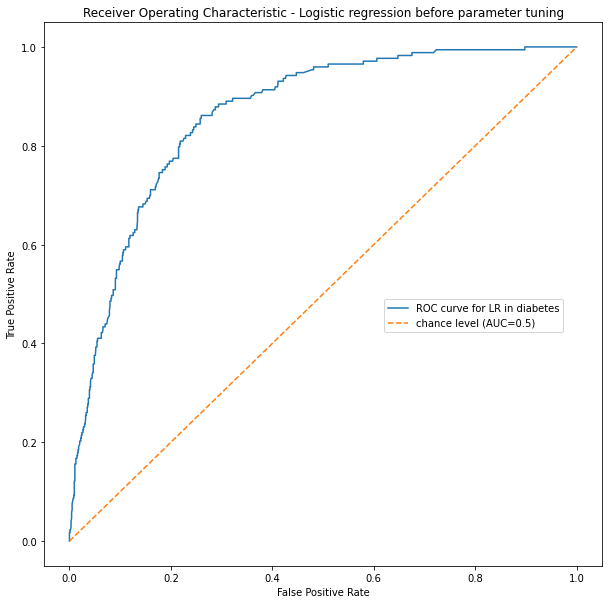

In [14]:
# Plot ROC curve for logistic regression model
y_score_lr = lr_clf.predict_proba(X_test)[:,1]
false_positive_rate_lr, true_positive_rate_lr, threshold_lr = roc_curve(y_test, y_score_lr)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score_lr))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression before parameter tuning')
plt.plot(false_positive_rate_lr, true_positive_rate_lr, label = "ROC curve for LR in diabetes")
plt.plot([0, 1], ls="--", label="chance level (AUC=0.5)")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend( bbox_to_anchor=(0.6,0.5))
plt.show()

[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

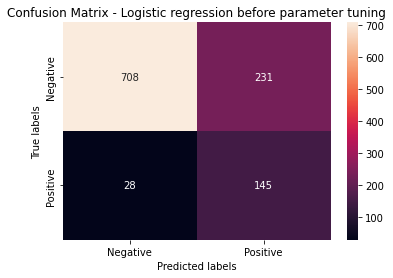

In [15]:
# Print confusion matrix for logistic regression model
cm = confusion_matrix(y_test, y_pred_lr1)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Logistic regression before parameter tuning')
ax.xaxis.set_ticklabels(["Negative", "Positive"])
ax.yaxis.set_ticklabels(["Negative", "Positive"])


# logistic regression with parameter tuning

In [16]:
# Define parameter distributions for random search on LR
c = stats.uniform(0, 10)
max_iter = [100, 200, 500]
solver = ['lbfgs','liblinear', 'newton-cholesky']
random_grid_lr = {'max_iter': max_iter, 'solver': solver, 'C': c}

In [34]:
# Train logistic regression model with random search and print evaluation metrics
lr = LogisticRegression()
lr_random = RandomizedSearchCV(estimator = lr, param_distributions = random_grid_lr, n_iter = 100, cv = 5, scoring='recall', random_state=11, n_jobs = -1)
lr_random.fit(X_val, y_val)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D164456F40>,
                                        'max_iter': [100, 200, 500],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cholesky']},
                   random_state=11, scoring='recall')

In [35]:
lr_random.best_params_

{'C': 7.853887219515014, 'max_iter': 100, 'solver': 'liblinear'}

In [39]:
best_random = LogisticRegression(C= 7.853887219515014, max_iter= 100, solver='liblinear', random_state=11)
best_random.fit(X_train_sm, y_train_sm)
y_pred_lr2 = best_random.predict(X_test)
accuracy = best_random.score(X_test, y_test)
print('Accuracy Score:', accuracy)
print('Prediction:', y_pred_lr2)
print(classification_report(y_test, y_pred_lr2))
confusion(y_test, y_pred_lr2)

Accuracy Score: 0.7679856115107914
Prediction: [0 0 1 ... 1 0 0]
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       939
           1       0.39      0.84      0.53       173

    accuracy                           0.77      1112
   macro avg       0.67      0.80      0.69      1112
weighted avg       0.87      0.77      0.80      1112

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         709         230
True[1]          28         145


,Predict[0],Predict[1]
True[0],709,230
True[1],28,145


roc_auc_score for Logistic Regression:  0.8623027818303816


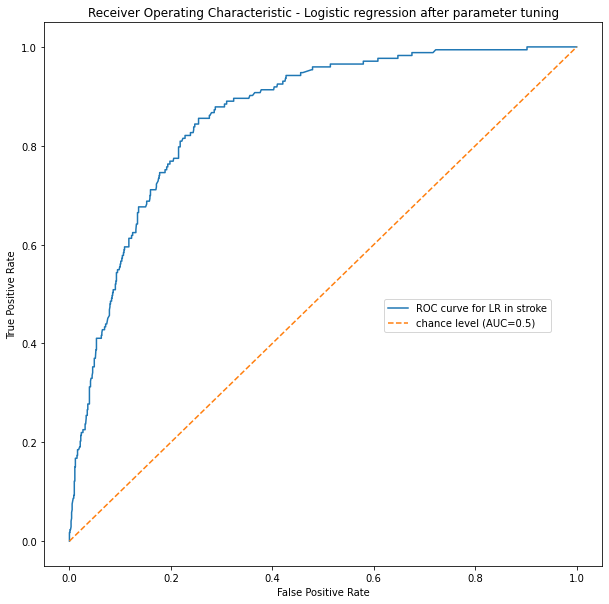

In [40]:
y_score_lr2 = best_random.predict_proba(X_test)[:,1]
false_positive_rate_lr2, true_positive_rate_lr2, threshold_lr2 = roc_curve(y_test, y_score_lr2)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score_lr2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression after parameter tuning')
plt.plot(false_positive_rate_lr2, true_positive_rate_lr2, label = "ROC curve for LR in stroke")
plt.plot([0, 1], ls="--", label="chance level (AUC=0.5)")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend( bbox_to_anchor=(0.6,0.5))
plt.show()

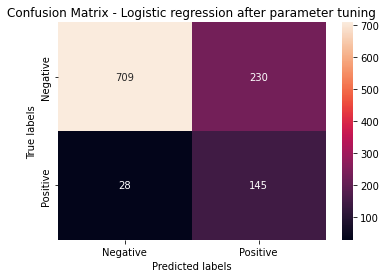

In [41]:
# Print confusion matrix for logistic regression model
cm = confusion_matrix(y_test, y_pred_lr2)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Logistic regression after parameter tuning'); 
ax.xaxis.set_ticklabels(["Negative", "Positive"]); ax.yaxis.set_ticklabels(["Negative", "Positive"]);


# Random Forest without parameter tuning

In [43]:
# Train random forest model with default parameters and print evaluation metrics
rnd_clf = RandomForestClassifier(random_state=11)
rnd_clf.fit(X_train_sm, y_train_sm)
y_pred_rnd1 = rnd_clf.predict(X_test)
accuracy = rnd_clf.score(X_test, y_test)
print('Accuracy Score:', accuracy)
print('Prediction:', y_pred_rnd1)
print(classification_report(y_test, y_pred_rnd1))
confusion(y_test, y_pred_rnd1)

Accuracy Score: 0.8345323741007195
Prediction: [0 0 0 ... 1 0 0]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       939
           1       0.46      0.41      0.44       173

    accuracy                           0.83      1112
   macro avg       0.68      0.66      0.67      1112
weighted avg       0.83      0.83      0.83      1112

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         857          82
True[1]         102          71


,Predict[0],Predict[1]
True[0],857,82
True[1],102,71


roc_auc_score for Random Forest:  0.814638005010865


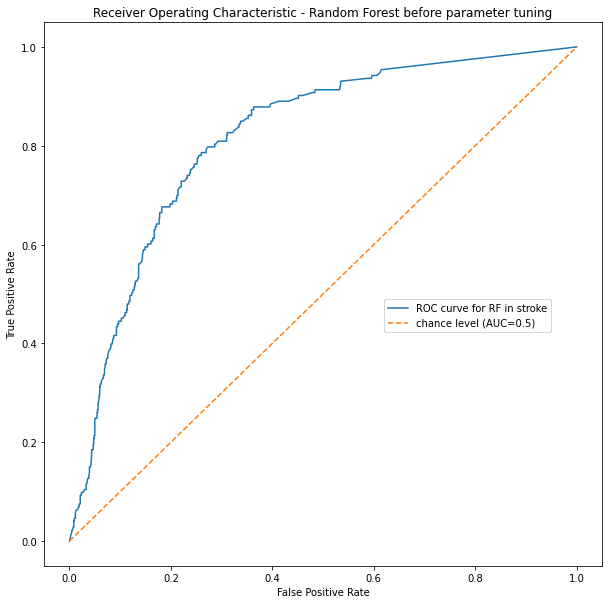

In [44]:
y_score_rnd1 = rnd_clf.predict_proba(X_test)[:,1]
false_positive_rate_rnd1, true_positive_rate_rnd1, threshold_rnd1 = roc_curve(y_test, y_score_rnd1)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score_rnd1))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest before parameter tuning')
plt.plot(false_positive_rate_rnd1, true_positive_rate_rnd1, label = "ROC curve for RF in stroke")
plt.plot([0, 1], ls="--", label="chance level (AUC=0.5)")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend( bbox_to_anchor=(0.6,0.5))
plt.show()

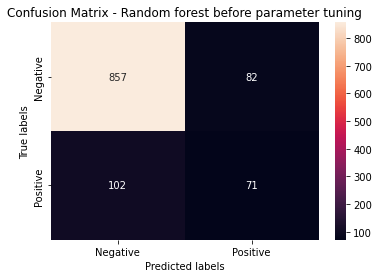

In [45]:
# Print confusion matrix for Random Forest model
cm = metrics.confusion_matrix(y_test, y_pred_rnd1)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Random forest before parameter tuning'); 
ax.xaxis.set_ticklabels(["Negative", "Positive"]); ax.yaxis.set_ticklabels(["Negative", "Positive"]);


# Random Forest with parameter tuning

In [62]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
        }

In [63]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, scoring='precision', random_state=11, n_jobs = -1)
rf_random.fit(X_val, y_val)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=11, scoring='precision')

In [64]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 10,
 'bootstrap': True}

In [65]:
best_random = rf_random.best_estimator_
best_random.fit(X_train_sm, y_train_sm)
y_pred_rnd2 = best_random.predict(X_test)
accuracy = best_random.score(X_test, y_test)
print('Accuracy Score:', accuracy)
print('Prediction:', y_pred_rnd2)
print(classification_report(y_test, y_pred_rnd2))
confusion(y_test, y_pred_rnd2)

Accuracy Score: 0.8264388489208633
Prediction: [0 0 1 ... 1 0 0]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       939
           1       0.46      0.69      0.55       173

    accuracy                           0.83      1112
   macro avg       0.70      0.77      0.72      1112
weighted avg       0.86      0.83      0.84      1112

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         800         139
True[1]          54         119


,Predict[0],Predict[1]
True[0],800,139
True[1],54,119


roc_auc_score for Random Forest:  0.8581106453181653


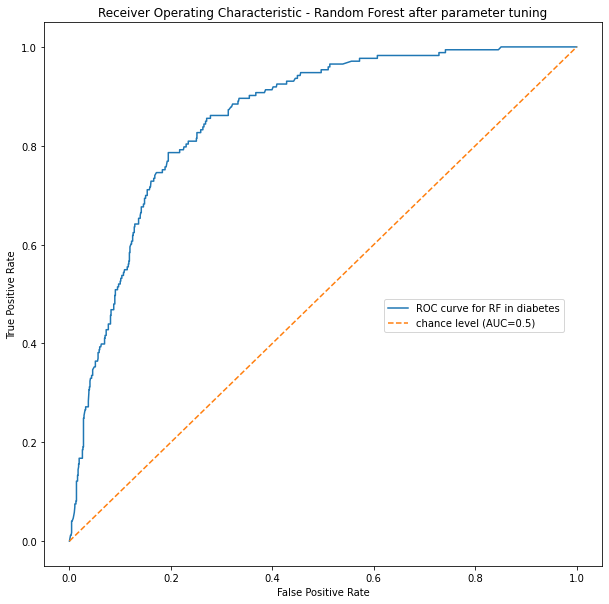

In [66]:
y_score_rnd2 = best_random.predict_proba(X_test)[:,1]
false_positive_rate_rnd2, true_positive_rate_rnd2, threshold_rnd2 = roc_curve(y_test, y_score_rnd2)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score_rnd2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest after parameter tuning')
plt.plot(false_positive_rate_rnd2, true_positive_rate_rnd2, label = "ROC curve for RF in diabetes")
plt.plot([0, 1], ls="--", label="chance level (AUC=0.5)")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend( bbox_to_anchor=(0.6,0.5))
plt.show()

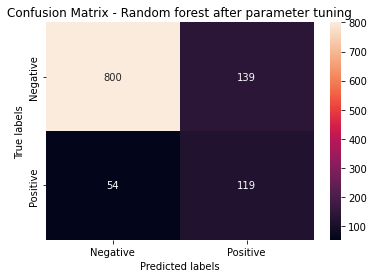

In [67]:
# Print confusion matrix for Random Forest model
cm = confusion_matrix(y_test, y_pred_rnd2)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Random forest after parameter tuning'); 
ax.xaxis.set_ticklabels(["Negative", "Positive"]); ax.yaxis.set_ticklabels(["Negative", "Positive"]);


# SVM without parameter tuning

In [69]:
# Train random forest model with default parameters and print evaluation metrics
svm_clf = SVC(random_state=1, probability=True)
svm_clf.fit(X_train_sm, y_train_sm)
y_pred_svm1 = svm_clf.predict(X_test)
accuracy = svm_clf.score(X_test, y_test)
print('Accuracy Score:', accuracy)
print('Prediction:', y_pred_svm1)

print(classification_report(y_test, y_pred_svm1))
confusion(y_test, y_pred_svm1)

Accuracy Score: 0.7805755395683454
Prediction: [1 0 1 ... 1 0 1]
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       939
           1       0.39      0.71      0.50       173

    accuracy                           0.78      1112
   macro avg       0.66      0.75      0.68      1112
weighted avg       0.85      0.78      0.80      1112

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         745         194
True[1]          50         123


,Predict[0],Predict[1]
True[0],745,194
True[1],50,123


roc_auc_score for SVM:  0.8344044519135472


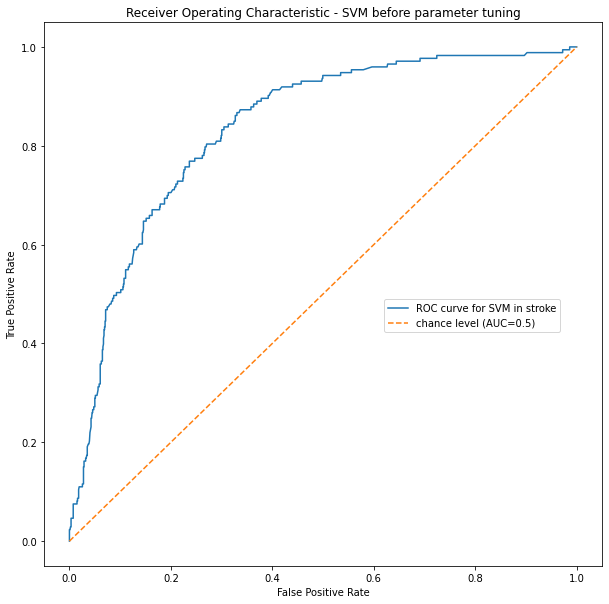

In [70]:
y_score_svm1 = svm_clf.predict_proba(X_test)[:,1]
false_positive_rate_svm1, true_positive_rate_svm1, threshold_svm1 = roc_curve(y_test, y_score_svm1)
print('roc_auc_score for SVM: ', roc_auc_score(y_test, y_score_svm1))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM before parameter tuning')
plt.plot(false_positive_rate_svm1, true_positive_rate_svm1, label = "ROC curve for SVM in stroke")
plt.plot([0, 1], ls="--", label="chance level (AUC=0.5)")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend( bbox_to_anchor=(0.6,0.5))
plt.show()

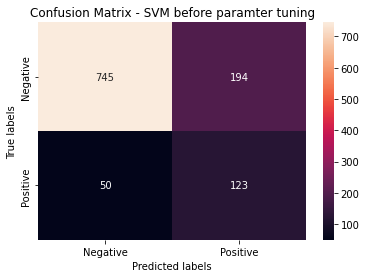

In [71]:
# Print confusion matrix for SVM model
cm = metrics.confusion_matrix(y_test, y_pred_svm1)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - SVM before paramter tuning'); 
ax.xaxis.set_ticklabels(["Negative", "Positive"]); ax.yaxis.set_ticklabels(["Negative", "Positive"]);


In [22]:
c = stats.uniform(0.1, 10)
gamma = stats.uniform(0.1, 1)
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

random_grid = {'C': c,
               'gamma': gamma,
               'kernel': kernel
               
        }
pprint(random_grid)

{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002754298CAF0>,
 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002754298C640>,
 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}


In [23]:
svm = SVC(random_state=1, probability=True)
svm_random = RandomizedSearchCV(estimator = svm, param_distributions = random_grid, n_iter = 100, cv = 5, scoring='roc_auc', n_jobs = -1)
svm_random.fit(X_val, y_val)

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002754298CAF0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002754298C640>,
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring='roc_auc')

In [24]:
svm_random.best_params_

{'C': 6.698191232251204, 'gamma': 0.9391285317691096, 'kernel': 'linear'}

In [25]:


best_random = svm_random.best_estimator_
best_random.fit(X_train_sm, y_train_sm)
y_pred_svm2 = best_random.predict(X_test)
accuracy = best_random.score(X_test, y_test)
print('Accuracy Score:', accuracy)
print('Prediction:', y_pred_svm2)
print(classification_report(y_test, y_pred_svm2))
confusion(y_test, y_pred_svm2)

Accuracy Score: 0.7517985611510791
Prediction: [0 0 1 ... 1 0 0]
              precision    recall  f1-score   support

           0       0.96      0.74      0.83       939
           1       0.37      0.84      0.51       173

    accuracy                           0.75      1112
   macro avg       0.67      0.79      0.67      1112
weighted avg       0.87      0.75      0.78      1112

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         691         248
True[1]          28         145


,Predict[0],Predict[1]
True[0],691,248
True[1],28,145


roc_auc_score for SVM:  0.8636201345669664


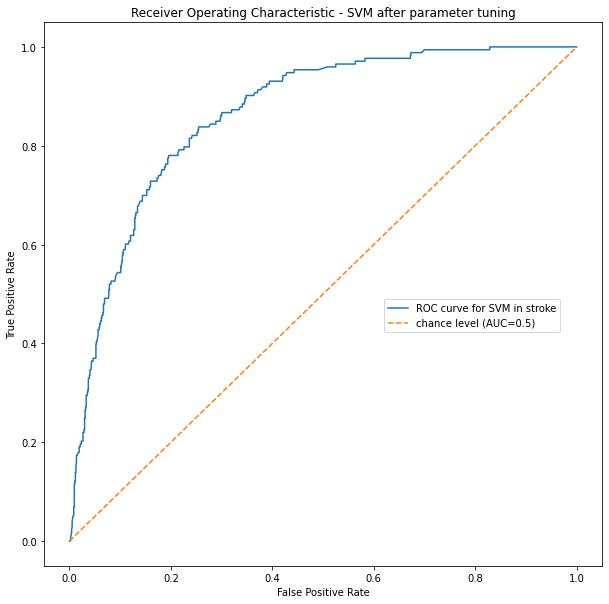

In [26]:
y_score_svm2 = best_random.predict_proba(X_test)[:,1]
false_positive_rate_svm2, true_positive_rate_svm2, threshold_svm2 = roc_curve(y_test, y_score_svm2)
print('roc_auc_score for SVM: ', roc_auc_score(y_test, y_score_svm2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM after parameter tuning')
plt.plot(false_positive_rate_svm2, true_positive_rate_svm2, label = "ROC curve for SVM in stroke")
plt.plot([0, 1], ls="--", label="chance level (AUC=0.5)")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend( bbox_to_anchor=(0.6,0.5))
plt.show()

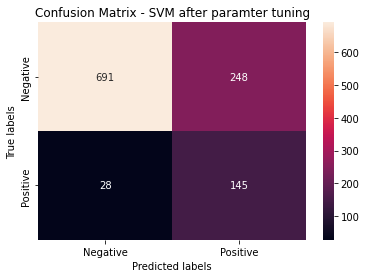

In [27]:
# Print confusion matrix for SVM model
cm = metrics.confusion_matrix(y_test, y_pred_svm2)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - SVM after paramter tuning'); 
ax.xaxis.set_ticklabels(["Negative", "Positive"]); ax.yaxis.set_ticklabels(["Negative", "Positive"]);
